# Causal Inference Example: Medication Effect on Blood Pressure

This notebook demonstrates a simple causal inference example using synthetic medical data and ordinary least squares regression. We'll explore how controlling for confounders leads to unbiased estimates of causal effects.

**Causal Model:**
- Treatment (M): Medication dosage (continuous)
- Outcome (BP): Blood pressure reduction (continuous)
- Confounder (A): Patient age (continuous)

We'll define a true data-generating process with a linear relationship, then estimate the causal effect both with and without controlling for the confounder.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Set random seed for reproducibility
np.random.seed(42)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

## 1. Define the True Causal Model

We'll create a separate function to generate our synthetic data. The true data-generating process is:

1. Age affects both medication dosage and blood pressure reduction
2. Medication affects blood pressure reduction
3. The true causal effect of medication on blood pressure reduction is known

This creates a classic confounding scenario where age is a common cause of both treatment and outcome.

In [2]:
def generate_medical_data(n_samples=1000, true_effect_medication=3, random_seed=None):
    """
    Generate synthetic medical data with a known causal structure.
    
    Parameters:
    - n_samples: Number of patients
    - true_effect_medication: True causal effect of medication on BP reduction
    - random_seed: Seed for random number generation
    
    Returns:
    - DataFrame with age, medication_dose, and bp_reduction
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Generate patient ages (the confounder)
    age = np.random.normal(loc=50, scale=10, size=n_samples)
    
    # Generate medication dosage (treatment) influenced by age
    # Older patients tend to get higher doses
    age_effect_on_med = 0.05  # Slope of age effect on medication
    med_base = 2  # Base medication level
    med_noise = np.random.normal(0, 0.5, n_samples)
    medication_dose = med_base + age_effect_on_med * (age - 50) + med_noise
    
    # Generate blood pressure reduction (outcome) influenced by both age and medication
    # Age has a negative effect (older patients see less reduction)
    age_effect_on_bp = -0.1  # Slope of age effect on BP reduction
    bp_base = 10  # Base BP reduction
    bp_noise = np.random.normal(0, 1, n_samples)
    bp_reduction = (bp_base + 
                   age_effect_on_bp * (age - 50) + 
                   true_effect_medication * medication_dose + 
                   bp_noise)
    
    # Create DataFrame
    data = pd.DataFrame({
        'age': age,
        'medication_dose': medication_dose,
        'bp_reduction': bp_reduction
    })
    
    return data, true_effect_medication

# Generate our synthetic data
data, true_effect = generate_medical_data(n_samples=1000, true_effect_medication=3)

# Display the first few rows
data.head()

,age,medication_dose,bp_reduction
0,54.967142,2.948035,17.672212
1,48.617357,2.393185,17.173300
2,56.476885,2.353659,15.620870
3,65.230299,2.438047,15.483148
4,47.658466,2.232035,15.036644


## 2. Explore the Data

Let's visualize the relationships between our variables to understand the confounding structure.

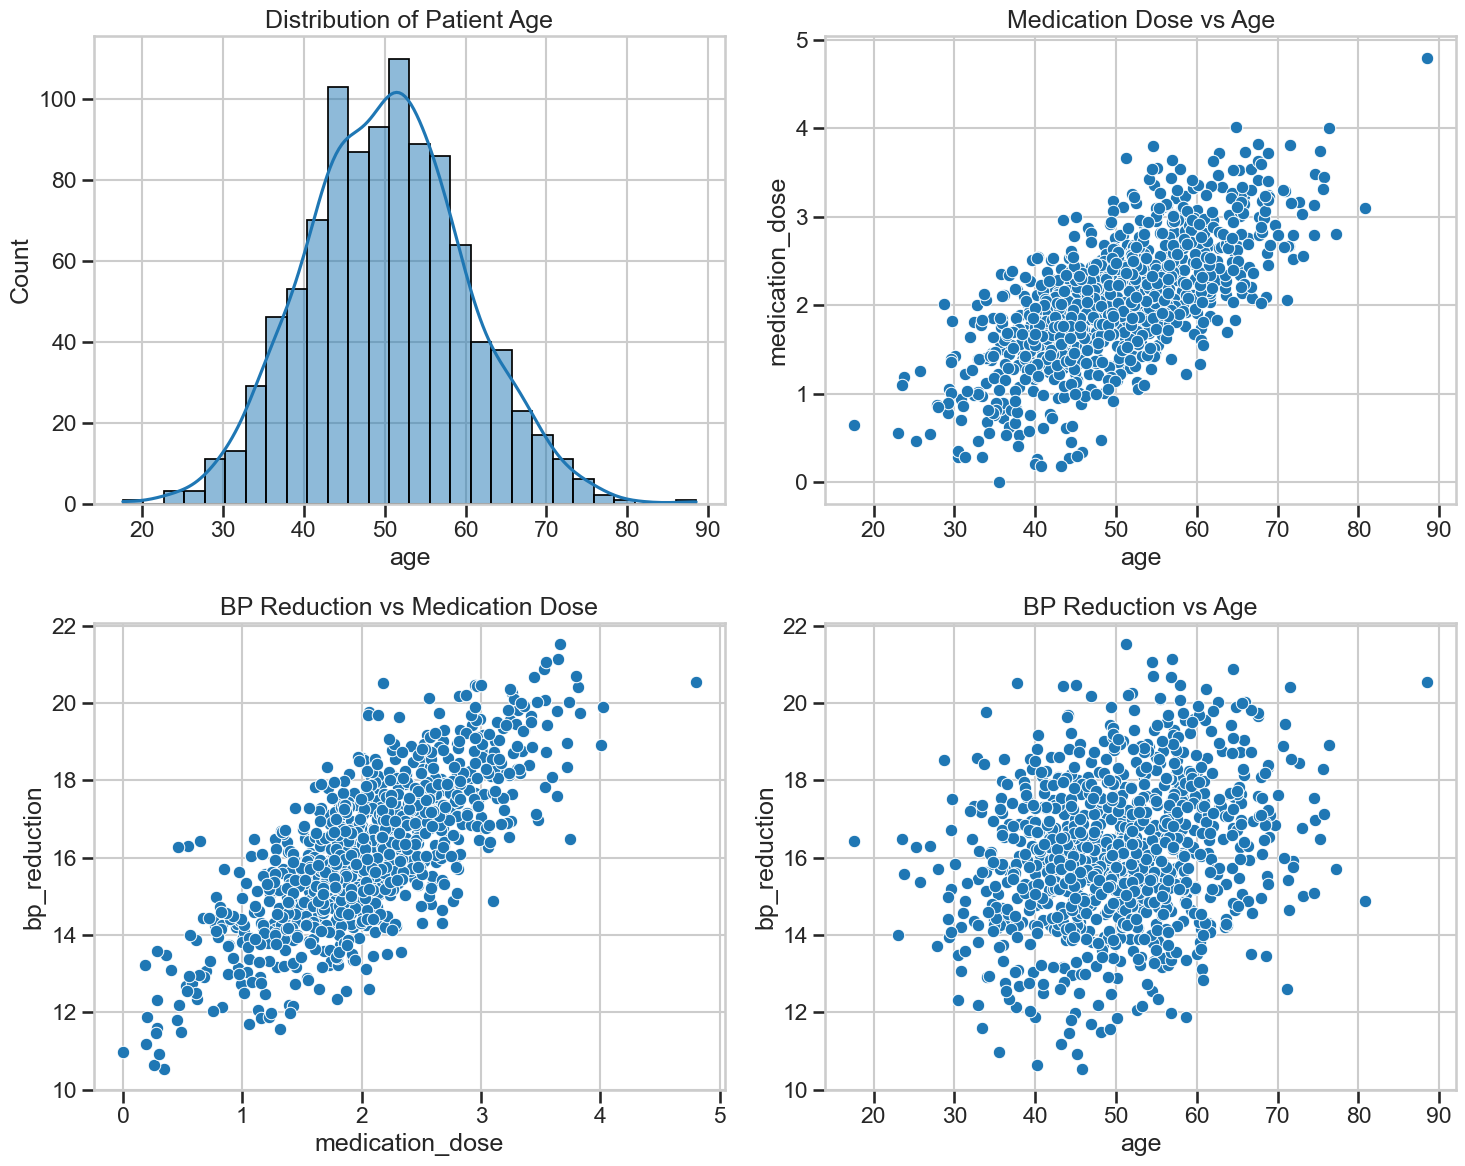

Correlation Matrix:
                      age  medication_dose  bp_reduction
age              1.000000         0.685715      0.245466
medication_dose  0.685715         1.000000      0.756641
bp_reduction     0.245466         0.756641      1.000000


In [3]:
# Plot distributions and relationships
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot age distribution
sns.histplot(data=data, x='age', kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Patient Age')

# Plot relationship between age and medication dose
sns.scatterplot(data=data, x='age', y='medication_dose', ax=axes[0, 1])
axes[0, 1].set_title('Medication Dose vs Age')

# Plot relationship between medication dose and BP reduction
sns.scatterplot(data=data, x='medication_dose', y='bp_reduction', ax=axes[1, 0])
axes[1, 0].set_title('BP Reduction vs Medication Dose')

# Plot relationship between age and BP reduction
sns.scatterplot(data=data, x='age', y='bp_reduction', ax=axes[1, 1])
axes[1, 1].set_title('BP Reduction vs Age')

plt.tight_layout()
plt.show()

# Calculate correlation matrix
correlation = data.corr()
print("Correlation Matrix:")
print(correlation)

## 3. Linear Regression Models

Now we'll implement two linear regression models:

1. **Naive model**: Ignores the confounder (age)
2. **Adjusted model**: Controls for the confounder (age)

We'll compare how well each model recovers the true causal effect of medication on blood pressure reduction.

In [4]:
# 1. Naive model (ignoring the confounder)
naive_model = ols('bp_reduction ~ medication_dose', data=data).fit()
print("Naive Model Summary (ignoring age):")
print(naive_model.summary().tables[1])  # Just print the coefficients table

# 2. Adjusted model (controlling for the confounder)
adjusted_model = ols('bp_reduction ~ medication_dose + age', data=data).fit()
print("\nAdjusted Model Summary (controlling for age):")
print(adjusted_model.summary().tables[1])  # Just print the coefficients table

# Extract and compare the medication coefficient estimates
naive_effect = naive_model.params['medication_dose']
naive_ci = naive_model.conf_int().loc['medication_dose']

adjusted_effect = adjusted_model.params['medication_dose']
adjusted_ci = adjusted_model.conf_int().loc['medication_dose']

print("\nComparison of Estimates:")
print(f"True causal effect: {true_effect:.2f}")
print(f"Naive estimate: {naive_effect:.2f} (95% CI: [{naive_ci[0]:.2f}, {naive_ci[1]:.2f}])")
print(f"Adjusted estimate: {adjusted_effect:.2f} (95% CI: [{adjusted_ci[0]:.2f}, {adjusted_ci[1]:.2f}])")

Naive Model Summary (ignoring age):
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          11.9697      0.120     99.947      0.000      11.735      12.205
medication_dose     2.0302      0.056     36.559      0.000       1.921       2.139

Adjusted Model Summary (controlling for age):
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          14.8869      0.164     90.680      0.000      14.565      15.209
medication_dose     2.9796      0.062     47.687      0.000       2.857       3.102
age                -0.0968      0.004    -22.158      0.000      -0.105      -0.088

Comparison of Estimates:
True causal effect: 3.00
Naive estimate: 2.03 (95% CI: [1.92, 2.14])
Adjusted estimate: 2.98 (95% CI: [2.86, 3.10])


## 4. Visualize the Estimates

Let's create a plot to compare the estimates from both models with the true causal effect.

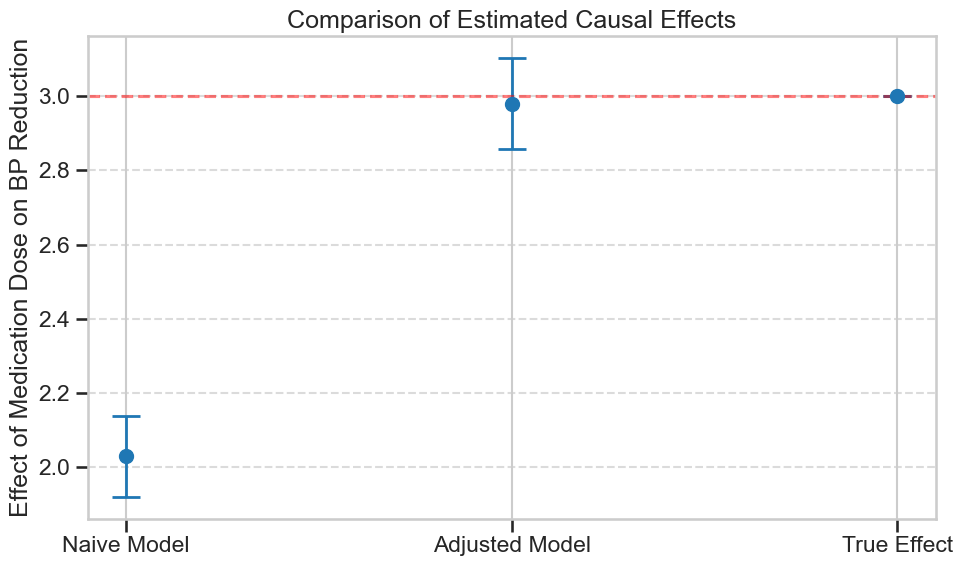

In [5]:
# Create a plot to compare estimates
plt.figure(figsize=(10, 6))

# Plot the estimates with confidence intervals
models = ['Naive Model', 'Adjusted Model', 'True Effect']
estimates = [naive_effect, adjusted_effect, true_effect]
lower_ci = [naive_ci[0], adjusted_ci[0], true_effect]  # No CI for true effect
upper_ci = [naive_ci[1], adjusted_ci[1], true_effect]  # No CI for true effect
errors = [(est - low, up - est) for est, low, up in zip(estimates, lower_ci, upper_ci)]

# Convert errors to the format expected by plt.errorbar
lower_errors = [errors[i][0] for i in range(len(errors))]
upper_errors = [errors[i][1] for i in range(len(errors))]
asymmetric_errors = [lower_errors, upper_errors]

plt.errorbar(models, estimates, yerr=asymmetric_errors, fmt='o', capsize=10, 
             markersize=10, elinewidth=2, capthick=2)

plt.axhline(y=true_effect, color='r', linestyle='--', alpha=0.5, label='True Effect')
plt.ylabel('Effect of Medication Dose on BP Reduction')
plt.title('Comparison of Estimated Causal Effects')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 5. Testing Robustness: Varying the Sample Size

Let's see how the estimates change with different sample sizes.

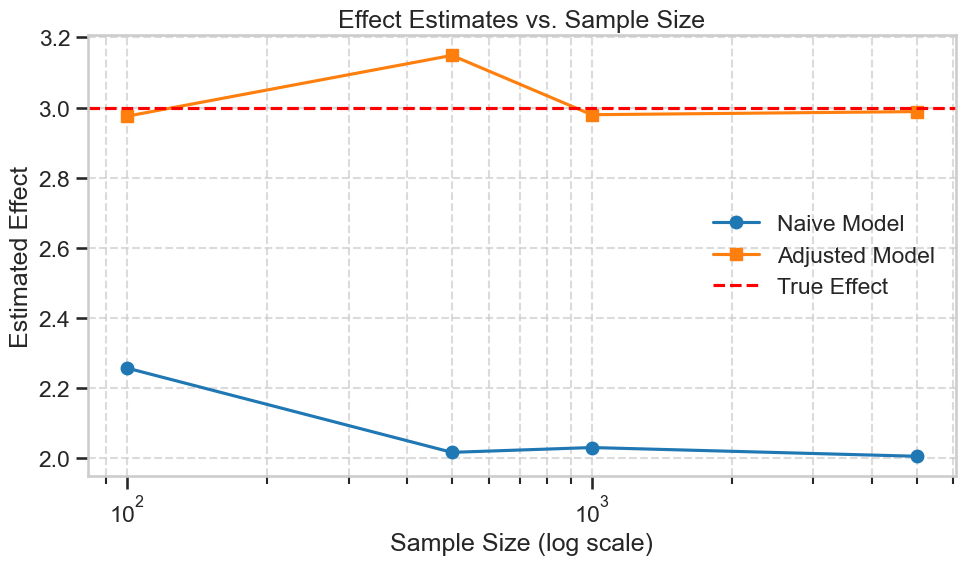

In [6]:
# Test with different sample sizes
sample_sizes = [100, 500, 1000, 5000]
naive_estimates = []
adjusted_estimates = []

for size in sample_sizes:
    # Generate data with this sample size
    sample_data, _ = generate_medical_data(n_samples=size, true_effect_medication=true_effect, random_seed=42)
    
    # Fit naive model
    naive = ols('bp_reduction ~ medication_dose', data=sample_data).fit()
    naive_estimates.append(naive.params['medication_dose'])
    
    # Fit adjusted model
    adjusted = ols('bp_reduction ~ medication_dose + age', data=sample_data).fit()
    adjusted_estimates.append(adjusted.params['medication_dose'])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, naive_estimates, 'o-', label='Naive Model')
plt.plot(sample_sizes, adjusted_estimates, 's-', label='Adjusted Model')
plt.axhline(y=true_effect, color='r', linestyle='--', label='True Effect')
plt.xscale('log')
plt.xlabel('Sample Size (log scale)')
plt.ylabel('Estimated Effect')
plt.title('Effect Estimates vs. Sample Size')
plt.legend()
plt.grid(True, which="both", linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 6. Conclusions

From our analysis, we can draw the following conclusions:

1. **Naive model (ignoring age)**: When we ignore the confounder (patient age), our estimate of the medication effect is biased. We get an incorrect estimate of the causal effect.

2. **Adjusted model (controlling for age)**: When we control for the confounder, our estimate is much closer to the true causal effect.

This example demonstrates a key principle in causal inference: **controlling for confounders is essential for obtaining unbiased estimates of causal effects**. When we ignore confounders, we get a misleading picture of the relationship between treatment and outcome.

In this medical example, age affects both the medication dosage that patients receive and their blood pressure response directly. Without accounting for age, we cannot separate the direct effect of medication from the indirect relationship through age.